In [1]:
library(tidyverse)
library(readxl)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
dieback = read_excel("input/Euc Dieback and Melaleuca metadata with indices.xlsx", na="NA") %>%
    janitor::clean_names() %>%
    filter(!if_all(everything(), is.na))

New names:
• `i5 name` -> `i5 name...8`
• `` -> `...13`
• `i5 name` -> `i5 name...14`
• `` -> `...16`


In [3]:
str(dieback)

tibble [1,923 × 28] (S3: tbl_df/tbl/data.frame)
 $ sample_no               : chr [1:1923] "NCT" "MON0000" "MON0001" "MON0002" ...
 $ plate                   : chr [1:1923] "MN01" "MN01" "MN01" "MN01" ...
 $ well_number             : chr [1:1923] "A01" "B1" "C1" "D1" ...
 $ nextera_indices_layout  : chr [1:1923] "Layout 5" "Layout 5" "Layout 5" "Layout 5" ...
 $ name                    : chr [1:1923] "B-0086" "B-0086" "B-0086" "B-0086" ...
 $ reverse_comp_for_novaseq: chr [1:1923] "WGS_I7_2" "WGS_I7_2" "WGS_I7_2" "WGS_I7_2" ...
 $ novaseq_i7              : chr [1:1923] "AACCAGGT" "AACCAGGT" "AACCAGGT" "AACCAGGT" ...
 $ i5_name_8               : chr [1:1923] "B-0078" "B-0079" "B-0080" "B-0081" ...
 $ forward_for_novaseq     : chr [1:1923] "WGS_I5_71" "WGS_I5_248" "WGS_I5_312" "WGS_I5_381" ...
 $ novaseq_i5              : chr [1:1923] "ATCTTGGT" "CTTCCTTG" "GCTGGCGG" "ACGTTACG" ...
 $ i7_name                 : chr [1:1923] "B-0086" "B-0086" "B-0086" "B-0086" ...
 $ reverse_comp_for_miseq 

In [4]:
dieback_pre = dieback %>%
    transmute(
        library=sample_no,
        sample = sample_no,
        plate,
        project=case_when(
            grepl("^MN", plate) ~ "MMackinnon",
            T ~ "MyrtleRust"
        ),
        well=well_number,
        i7 = reverse_comp_for_novaseq,
        novaseq_i7,
        i5 = forward_for_novaseq,
        novaseq_i5,
        latitude,
        longitude,
        elevation,
        species,
        date,
        time,
        notes=note,
        percent_dieback,
        seed,
        seed_amount,
    )

In [5]:
str(dieback_pre)

tibble [1,923 × 19] (S3: tbl_df/tbl/data.frame)
 $ library        : chr [1:1923] "NCT" "MON0000" "MON0001" "MON0002" ...
 $ sample         : chr [1:1923] "NCT" "MON0000" "MON0001" "MON0002" ...
 $ plate          : chr [1:1923] "MN01" "MN01" "MN01" "MN01" ...
 $ project        : chr [1:1923] "MMackinnon" "MMackinnon" "MMackinnon" "MMackinnon" ...
 $ well           : chr [1:1923] "A01" "B1" "C1" "D1" ...
 $ i7             : chr [1:1923] "WGS_I7_2" "WGS_I7_2" "WGS_I7_2" "WGS_I7_2" ...
 $ novaseq_i7     : chr [1:1923] "AACCAGGT" "AACCAGGT" "AACCAGGT" "AACCAGGT" ...
 $ i5             : chr [1:1923] "WGS_I5_71" "WGS_I5_248" "WGS_I5_312" "WGS_I5_381" ...
 $ novaseq_i5     : chr [1:1923] "ATCTTGGT" "CTTCCTTG" "GCTGGCGG" "ACGTTACG" ...
 $ latitude       : num [1:1923] -37.1 -37.1 -37.1 -37.1 -37.1 ...
 $ longitude      : num [1:1923] 149 149 149 149 149 ...
 $ elevation      : num [1:1923] NA NA NA NA NA NA NA NA NA NA ...
 $ species        : chr [1:1923] "E. radiata" "E. viminalis" "E. dives" 

In [6]:
dp15_seq = read_tsv("input/runlib2sample.tsv") %>%
    rename(seq_date=date)

Rows: 2920 Columns: 6
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): run, library, sample, include, project, date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
dp15_meta = read_tsv("input/sample-metadata.tsv") %>%
    unique()

Rows: 1746 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (10): sample, species, date, datum, location, collectors, samplename, p...
dbl   (3): latitude, longitude, elevation
dttm  (1): parsed_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


This is needed as we have a few duplicates for the CCAs. The below horrible filter statement picks the most data complete ones (remove it to see)

In [8]:
dp15_meta_pre = dp15_meta %>%
    group_by(sample) %>%
    mutate(n=n()) %>%
    ungroup() %>%
    arrange(sample)  %>%
    filter(n==1 | (n != 1  & is.na(samplename)))

In [9]:
dp15_pre = left_join(dp15_seq, dp15_meta_pre, by="sample")

In [10]:
dp15_pre %>%
    filter(is.na(n))

run,library,sample,include,project,seq_date,species,date,parsed_date,latitude,longitude,elevation,datum,location,collectors,samplename,population,seed,notes,n
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
2020_Borevitz_UWA_S4,A_acuminata_ANBG_1,Acacia_acuminata_ANBG,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020_Borevitz_UWA_S4,A_acuminata_ANBG_2,Acacia_acuminata_ANBG,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020_Borevitz_UWA_S4,A_dealbata_1,Acacia_dealbata,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020_Borevitz_UWA_S4,A_dealbata_2,Acacia_dealbata,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020_Borevitz_UWA_S4,A_melanoxylon_1,Acacia_melanoxylon,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020_Borevitz_UWA_S4,A_melanoxylon_2,Acacia_melanoxylon,Y,AcaciaPan,2020-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021_Bothwell_novogene_S4,NCT,NCT,N,HBDecra,2021-03,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021_Bothwell_novogene_S4,NCT_1,NCT_1,N,HBDecra,2021-03,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021_Bothwell_novogene_S4,NCT_3,NCT_3,N,HBDecra,2021-03,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [11]:
str(dp15_pre)

spc_tbl_ [2,920 × 20] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ run        : chr [1:2920] "2020_Borevitz_UWA_S4" "2020_Borevitz_UWA_S4" "2020_Borevitz_UWA_S4" "2020_Borevitz_UWA_S4" ...
 $ library    : chr [1:2920] "A_acuminata_ANBG_1" "A_acuminata_ANBG_2" "A_dealbata_1" "A_dealbata_2" ...
 $ sample     : chr [1:2920] "Acacia_acuminata_ANBG" "Acacia_acuminata_ANBG" "Acacia_dealbata" "Acacia_dealbata" ...
 $ include    : chr [1:2920] "Y" "Y" "Y" "Y" ...
 $ project    : chr [1:2920] "AcaciaPan" "AcaciaPan" "AcaciaPan" "AcaciaPan" ...
 $ seq_date   : chr [1:2920] "2020-01" "2020-01" "2020-01" "2020-01" ...
 $ species    : chr [1:2920] NA NA NA NA ...
 $ date       : chr [1:2920] NA NA NA NA ...
 $ parsed_date: POSIXct[1:2920], format: NA NA ...
 $ latitude   : num [1:2920] NA NA NA NA NA ...
 $ longitude  : num [1:2920] NA NA NA NA NA ...
 $ elevation  : num [1:2920] NA NA NA NA NA NA 153 253 259 279 ...
 $ datum      : chr [1:2920] NA NA NA NA ...
 $ location   : chr [1:2920] NA NA NA N

In [12]:
cca_all = read_excel("input/CCATreesCombinedMetadata_ash.xlsx", na = "NA", guess_max = 100000) %>%
    janitor::clean_names()

In [13]:
str(cca_all)

tibble [6,098 × 24] (S3: tbl_df/tbl/data.frame)
 $ field_id           : chr [1:6098] "CCA0001" "CCA0002" "CCA0003" "CCA0004" ...
 $ row_tree           : chr [1:6098] "R009/T03" "R009/T04" "R009/T05" "R009/T09" ...
 $ current_name       : chr [1:6098] "Eucalyptus leptopoda subsp. elevata" "Eucalyptus leptopoda subsp. elevata" "Eucalyptus mannensis subsp. mannensis" "Eucalyptus gamophylla" ...
 $ voucher            : chr [1:6098] "DN 8" "DN 8" "-" "-" ...
 $ provenance         : chr [1:6098] "Ilkurlka, WA" "Ilkurlka, WA" "Giles, WA" "Kings Canyon, NT" ...
 $ row_num            : num [1:6098] 9 9 9 9 9 9 9 9 9 9 ...
 $ year_planted       : num [1:6098] 1993 1993 1993 1993 1993 ...
 $ tree_num           : num [1:6098] 3 4 5 9 14 15 16 17 18 19 ...
 $ dn_number          : num [1:6098] 8 8 NA NA NA NA NA NA NA NA ...
 $ field_comments     : chr [1:6098] NA NA NA NA ...
 $ date               : POSIXct[1:6098], format: NA NA ...
 $ field_determination: chr [1:6098] "Eucalyptus leptopoda subsp.

In [14]:
cca_pre = cca_all %>%
    transmute(
        sample=field_id,
        species=current_name,
        location,
        latitude,
        longitude, 
        date = as.Date(date),
        notes = field_comments,
    )

In [15]:
all_eucs =  bind_rows(dp15_pre, dieback_pre) %>%
    mutate(
        parsed_date = case_when(
            !is.na(as.numeric(date)) ~ as.Date(as.numeric(date), origin = "1899-12-30"),
            grepl("\\d{2}-(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)-\\d+", date, perl=T) ~ lubridate::dmy(sub(" .+", "", date)),
            grepl("T.+Z", date) ~ lubridate::ymd(sub("T.+Z", "", date)),
            grepl("\\d+/\\d+/\\d{4}", date) ~ lubridate::dmy(date),
            
        ),
        latitude=ifelse(latitude==0, NA, latitude),
        longitude=ifelse(longitude==0, NA, longitude),
        species=ifelse(species=="0", NA, species),
        species=sub("E. ", "Eucalyptus ", species, fixed=T),
        errors = "",
        errors = case_when(
            (is.na(latitude) & is.na(longitude)) | (latitude > -44 & latitude < -10 & longitude > 110 & longitude < 155) ~ errors,
            T ~ paste0(errors, "latlong;")
        ),
    )

Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `parsed_date = case_when(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


In [16]:
write_tsv(all_eucs, "all_merged_euc_metadata.tsv", na="")

# Plots

Warning message:
“Ignoring unknown aesthetics: x, y”
Warning message:
“Removed 1070 rows containing missing values (geom_point).”
Warning message:
“Removed 1070 rows containing missing values (geom_point).”


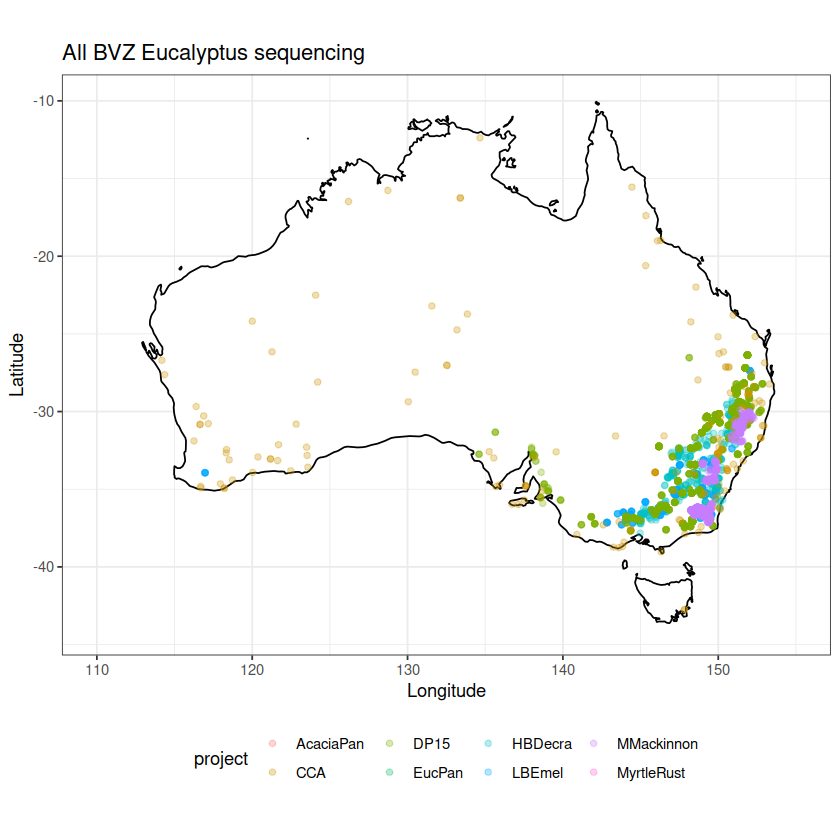

In [17]:
aus = map_data("world", "Australia")
all_eucs %>%
    rename(lat=latitude, long=longitude) %>%
ggplot(aes(long, lat)) +
    geom_map(aes(long, lat, group=group, map_id=region), data=aus, map=aus, colour="black", fill="white") + 
    geom_point(aes(colour=project), alpha=0.3) +
    xlim(c(110, 155)) +
    ylim(c(-44, -10)) +
    labs(title="All BVZ Eucalyptus sequencing", x="Longitude", y="Latitude") + 
    coord_fixed() +
    theme_bw() +
    theme(legend.position="bottom")
#ggsave("map.svg", width=8, height=8)
ggsave("map.png", width=8, height=8, dpi=600)